# PokeClassifier

Gen1 Pokemon Image Classifier with Automatic Image Standardization

## Imports and Setup

In [1]:
# Setup to suppress gpu acceleration messages
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Datapaths and model hyperparameters

In [2]:
# Data location
train_path = 'TrainImages'
test_path = 'TestImages'

# Data perturbation and preprocessing
IMAGE_SHAPE = (224,224)
ROT_RANGE = 0.1
TRANS_RANGE = (-0.1, 0.1)
ZOOM_RANGE = (-0.1, 0.1)
VAL_SPLIT = 0.1
SPLIT_SEED = 1

# Model and Training
DROPOUT_PROP = 0.5
LEARNING_RATE = 0.001
EPOCH_TRAIN = 30 # Early stopping used, this is upper limit
BATCH_SIZE = 32
FINE_TUNE_LAYERS = 40
EPOCH_FINE = 15 # Early stopping used, this is upper limit

## Initialize Image Generators

Utilize Keras's ImageDataGenerator to load both training and testing dataset images for the model. Will use 10% of the training set for validation when trainig the model. Since we have a small dataset, we introduce data augmentation in the generator with random flips, small rotations, and shifts to reduce overfitting.

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd

train_dataset = image_dataset_from_directory(train_path, 
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SHAPE,
                                             label_mode='categorical',
                                             labels='inferred',
                                             validation_split=VAL_SPLIT,
                                             subset='training',
                                             seed=SPLIT_SEED,)

# Use 10% of training to form validation
val_dataset = image_dataset_from_directory(train_path, 
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMAGE_SHAPE,
                                            label_mode='categorical',
                                            labels='inferred',
                                            validation_split=VAL_SPLIT,
                                            subset='validation',
                                            seed=SPLIT_SEED,)

# For displaying, import a loader with string labels
sample_dataset = image_dataset_from_directory(test_path, shuffle=True, image_size=IMAGE_SHAPE,)

# Save one hot encoding
encoding = pd.Series(train_dataset.class_names, name='name')
encoding.to_csv('one_hot_encoding.csv')

Found 5830 files belonging to 149 classes.
Using 5247 files for training.
Found 5830 files belonging to 149 classes.
Using 583 files for validation.
Found 949 files belonging to 149 classes.


### Sample images

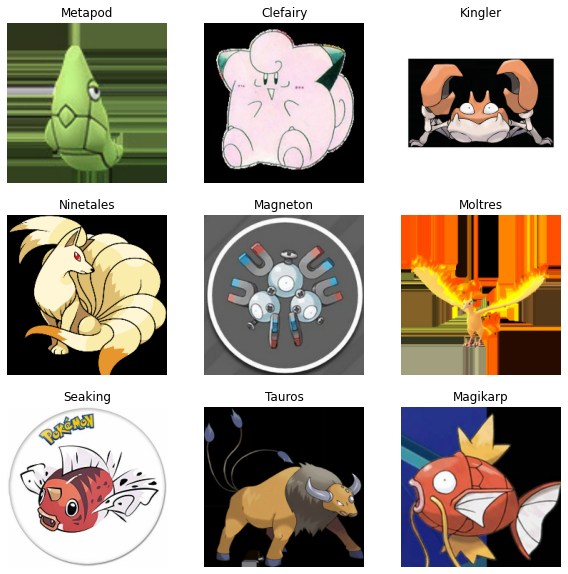

In [4]:
import matplotlib.pyplot as plt

class_labels = sample_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in sample_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

### Standardization and perturbation layer

In [5]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(ROT_RANGE),
    layers.RandomTranslation(TRANS_RANGE, TRANS_RANGE, fill_mode='nearest'),
    layers.RandomZoom(ZOOM_RANGE, ZOOM_RANGE, fill_mode='nearest'),
], name='data_augmentation')

### Sample training images

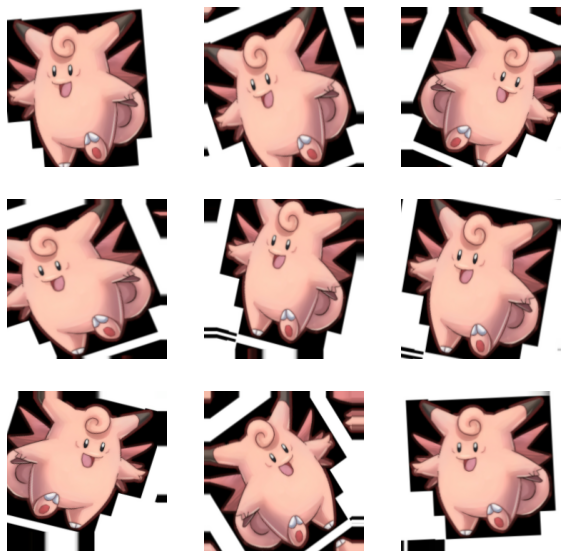

In [6]:
for image, _ in sample_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Preprocessing layer for base model

We will be using ResNet50 as our base model and thus need to use its preprocessing layer to properly format images.

In [7]:
from tensorflow.keras.applications import resnet_v2

preprocess_input = resnet_v2.preprocess_input

### Performance optimization

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## Model Definition

We will use ResNet50 as our base model with our own classification head. Softmax activation will be used to convert the output into probabilities for each label in the output layer

### Base ResNet50 instantiation

In [9]:
INPUT_DIM = IMAGE_SHAPE + (3,)
base_model = resnet_v2.ResNet50V2(input_shape=INPUT_DIM,include_top=False,weights='imagenet')

base_model.trainable = False

### Classification head

In [10]:
# Average pooling layer to flatten ResNet CNN output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='global_average')

# Output layer
output_layer = layers.Dense(149,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001),name='output')

### Building and compiling model

In [11]:
from tensorflow.keras.optimizers import Adam

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_PROP)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                             

## Training

To best balance training and overfitting, we will utilize keras's EarlyStopping callback to halt training once overfitting is detected by a decrease in validation accuracy. Checkpointing is used to save the model with the best validation performance to be later fine tuned, evaluated, and used as a classifier.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint("poke_model",
                                                monitor="val_loss",
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode="min")
early_stopping = EarlyStopping(monitor='val_loss',patience=2)

results = model.fit(train_dataset,
                    epochs=EPOCH_TRAIN,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, checkpoint],)

Epoch 1/30
164/164 [==============================] - 256s 1s/step - loss: 4.5333 - accuracy: 0.1633 - val_loss: 2.7459 - val_accuracy: 0.4906
Epoch 2/30
164/164 [==============================] - 237s 1s/step - loss: 2.5999 - accuracy: 0.4719 - val_loss: 2.1529 - val_accuracy: 0.6295
Epoch 3/30
164/164 [==============================] - 240s 1s/step - loss: 2.0836 - accuracy: 0.6112 - val_loss: 1.9318 - val_accuracy: 0.6810
Epoch 4/30
164/164 [==============================] - 239s 1s/step - loss: 1.8249 - accuracy: 0.6745 - val_loss: 1.8623 - val_accuracy: 0.6810
Epoch 5/30
164/164 [==============================] - 238s 1s/step - loss: 1.6841 - accuracy: 0.7115 - val_loss: 1.7507 - val_accuracy: 0.7221
Epoch 6/30
164/164 [==============================] - 235s 1s/step - loss: 1.5717 - accuracy: 0.7353 - val_loss: 1.7292 - val_accuracy: 0.7256
Epoch 7/30
164/164 [==============================] - 232s 1s/step - loss: 1.5046 - accuracy: 0.7561 - val_loss: 1.6563 - val_accuracy: 0.7376

### Training summary

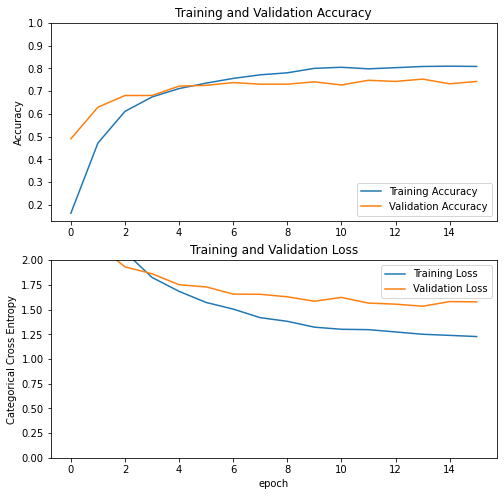

In [13]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

Train higher layers of the base model for this dataset for more performance

In [14]:
# Load best version
model.load_weights('poke_model')

# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = True
for layer in base_model.layers[:(len(base_model.layers) - FINE_TUNE_LAYERS)]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE/50),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                             

In [15]:
fine_start = results.epoch[-1]

history_fine = model.fit(train_dataset,
                         epochs=EPOCH_TRAIN + EPOCH_FINE,
                         initial_epoch=results.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[early_stopping, checkpoint],)

Epoch 16/45
164/164 [==============================] - 262s 1s/step - loss: 1.5471 - accuracy: 0.7416 - val_loss: 1.3063 - val_accuracy: 0.7770
Epoch 17/45
164/164 [==============================] - 246s 1s/step - loss: 1.1146 - accuracy: 0.8508 - val_loss: 1.2306 - val_accuracy: 0.8045
Epoch 18/45
164/164 [==============================] - 265s 2s/step - loss: 0.9452 - accuracy: 0.8937 - val_loss: 1.1443 - val_accuracy: 0.8233
Epoch 19/45
164/164 [==============================] - 274s 2s/step - loss: 0.8248 - accuracy: 0.9234 - val_loss: 1.0928 - val_accuracy: 0.8388
Epoch 20/45
164/164 [==============================] - 274s 2s/step - loss: 0.7602 - accuracy: 0.9381 - val_loss: 1.0355 - val_accuracy: 0.8576
Epoch 21/45
164/164 [==============================] - 273s 2s/step - loss: 0.7231 - accuracy: 0.9432 - val_loss: 0.9959 - val_accuracy: 0.8645
Epoch 22/45
164/164 [==============================] - 249s 2s/step - loss: 0.6725 - accuracy: 0.9541 - val_loss: 0.9570 - val_accuracy:

### Fine tuning summary

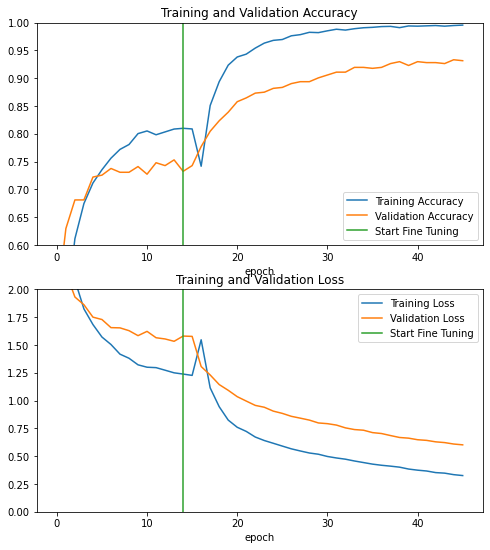

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 9))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([fine_start - 1,fine_start - 1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([fine_start - 1,fine_start - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Final Evaluation

Evaluating performance on the testing dataset

In [17]:
test_dataset = image_dataset_from_directory(test_path,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMAGE_SHAPE,
                                            label_mode='categorical',
                                            labels='inferred',)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Load and save best version
model.load_weights('poke_model')
model.save_weights("Results/r50v2_4")

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 949 files belonging to 149 classes.
30/30 [==============================] - 8s 228ms/step - loss: 0.5890 - accuracy: 0.9294
Test accuracy : 0.9293993711471558
